In [1]:
# in the name of god 

In [2]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
#prepare Dataset gyroscope
dfg=pd.read_csv('20\giroscopio_terra.csv')
dfg['ts']=pd.to_datetime(dfg.apply(lambda x:(round((x.uptimeNanos-dfg.uptimeNanos[0])/1000000)*1000000),axis=1))
dm=dfg['ts']
dfg=dfg.drop('uptimeNanos',1).drop('timestamp',1)
dfg=dfg.set_index('ts').rename(columns={'x': 'g-x','y': 'g-y','z': 'g-z'})
dfg.head(3)

,g-x,g-y,g-z
ts,,,
1970-01-01 00:00:00.000,0.024461,0.011438,-0.064492
1970-01-01 00:00:00.010,-0.016953,-0.011038,-0.055165
1970-01-01 00:00:00.025,-0.024161,0.030720,-0.074291


In [4]:
#prepare Dataset accelarator
dfa=pd.read_csv('20\\acelerometro_terra.csv')
dfa['ts']=dm
dfa=dfa.drop('uptimeNanos',1).drop('timestamp',1)
dfa=dfa.set_index('ts').rename(columns={'x': 'a-x','y': 'a-y','z': 'a-z'})
dfa.head(3)

,a-x,a-y,a-z
ts,,,
1970-01-01 00:00:00.000,-0.080265,-0.333322,9.830113
1970-01-01 00:00:00.010,-0.154129,-0.448813,9.740011
1970-01-01 00:00:00.025,-0.095645,-0.264550,9.761985


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B76556208>,
      dtype=object)

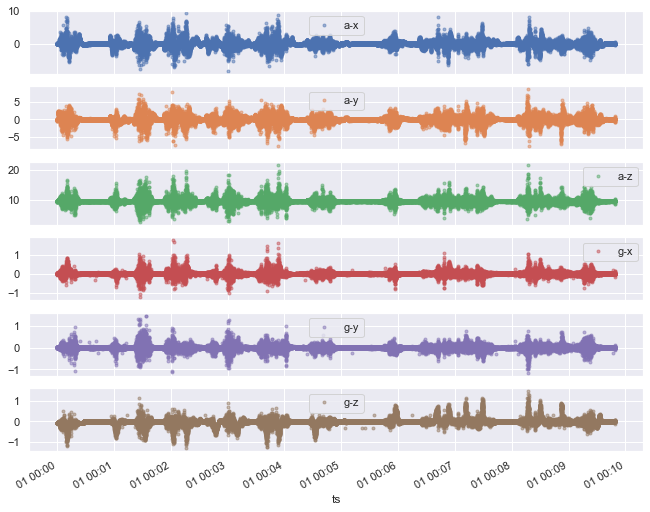

In [5]:
df = pd.concat([dfa, dfg], axis=1, join='outer')
df.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

In [6]:
#prepare Labeled dataset
dfl=pd.read_csv('20\\groundTruth.csv')
dfl['length']=dfl.en-dfl.st
lmean=dfl.length.mean()
lstd=dfl.length.std()

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)

dfl['st_time']=dfl.apply(lambda x:time_convertor(x.st) ,axis=1 )
dfl['en_time']=dfl.apply(lambda x:time_convertor(x.en) ,axis=1 )
dfl=dfl.drop('st',1).drop('en',1).drop('length',1)
evented_label=list()
for i in range(len(dfl)):
    evented_label.append((dfl.iloc[i][0],dfl.iloc[i][1],dfl.iloc[i][2]))

In [7]:
#Dont RUN this part
#we should optimize M
#lengh of random event
from random import gauss
L=round(gauss(lmean,lstd)*50)
M=round(gauss(0.5,0.5)*50)

temp_event=list()
pointer=0
stop=False
#go on timeserise for event extraction
while stop!=True:
    clear_output(wait=True)
    M=round(gauss(0.5,0.5)*50)
    pointer=pointer + M
    #go forward till reach M
    L=round(gauss(lmean,lstd)*50)
    l_min=pointer-int(L/2)
    l_max=pointer+int(L/2)
    if (l_min<0):
        l_min=0
    if (l_max>len(df)):
        l_max=len(df)
        stop=True

    print('extraction ',l_max/len(df),' %  is complete')
    
    temp_event.append(df[l_min:l_max])


extraction  1.0  %  is complete


In [8]:
#Dont RUN this part
#calculate distance
from fastdtw import fastdtw
distance=list()
n=0
k=(len(temp_event))
k=k*k
t1=time.time()
for i,x in enumerate(temp_event):
    dumy=list()
    for j,y in enumerate(temp_event):
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
        if (i<=j):
            continue
        else:
            dist,_=fastdtw(x,y)
            dumy.append(dist)
        
    distance.append(dumy)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')


disstance calculatoin  100.0  %  is complete
1186 min has time for calculaton distant


In [9]:
#Dont RUN this part
#clustering precision
n=0
k=len(temp_event)*len(evented_label)
labels_distance=list()

for tag,st,en in evented_label:
    dummy=list()
    for t_e in temp_event:
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,2),' %  is complete')
        dist,_=fastdtw(df[st:en],t_e)
        dummy.append(dist)
    labels_distance.append((tag,dummy))


disstance calculatoin  100.0  %  is complete


In [10]:
#Save temp_event
with open("temp_event_on20.txt", "wb") as fp:
    pickle.dump(temp_event, fp)
    
#Save distance matrix
with open("distance_on20.txt", "wb") as fp:
    pickle.dump(distance, fp)
    
#Save labeds distance matrix
with open("labels_distance_on20.txt", "wb") as fp:
    pickle.dump(labels_distance, fp)
    

In [7]:
#load File , save the time of calculation
with open("temp_event_on20.txt", "rb") as fp:
    te = pickle.load(fp)
with open("distance_on20.txt", "rb") as fp:
    dc = pickle.load(fp)
with open("labels_distance_on20.txt", "rb") as fp:
    ld = pickle.load(fp)

In [8]:
#make it as matrix 
#full it with zero for squaring
from copy import deepcopy
def creat_Symmetric_matrix(file):  
    MTX=deepcopy(file)
    for i in range(len(MTX)):
        while len(MTX[i])!=len(MTX):
            MTX[i].append(0)
    #make it Symmetry from diameter
    arr=np.array(MTX)
    dis=np.array(MTX)
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (i>j):
                dis[j][i]=arr[i][j]
    return dis
dis=creat_Symmetric_matrix(dc)

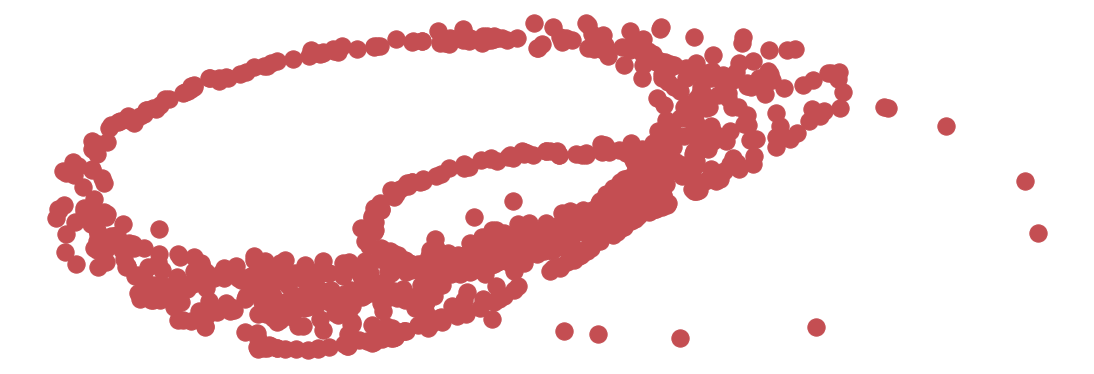

In [13]:
#PLOT GRAPH
import networkx as nx
G = G=nx.from_numpy_matrix(dis)
nx.draw(G,edge_color ='w', edge_cmap=plt.cm.winter ,node_color='r')

No handles with labels found to put in legend.


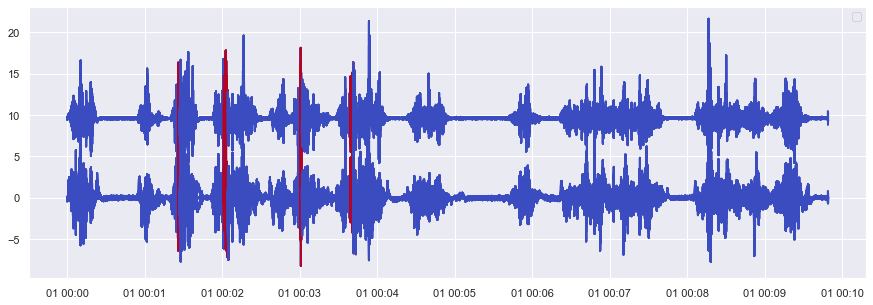

In [9]:
#initial clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

cluster = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average').fit(dis)

plot_list=list()
for i,el in enumerate(te):
    plot_list.append((el,cluster.labels_[i]))
    
fig, ax = plt.subplots()

for el in plot_list:
    ax.plot(el[0], linestyle='-', linewidth=2,c=color_map_color(el[1]*10))
ax.legend();
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


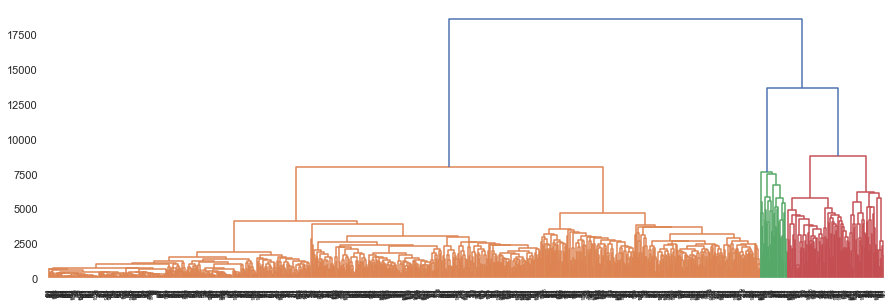

In [15]:
Z = hierarchy.linkage(dis, 'average')
plt.figure()
dn = hierarchy.dendrogram(Z)

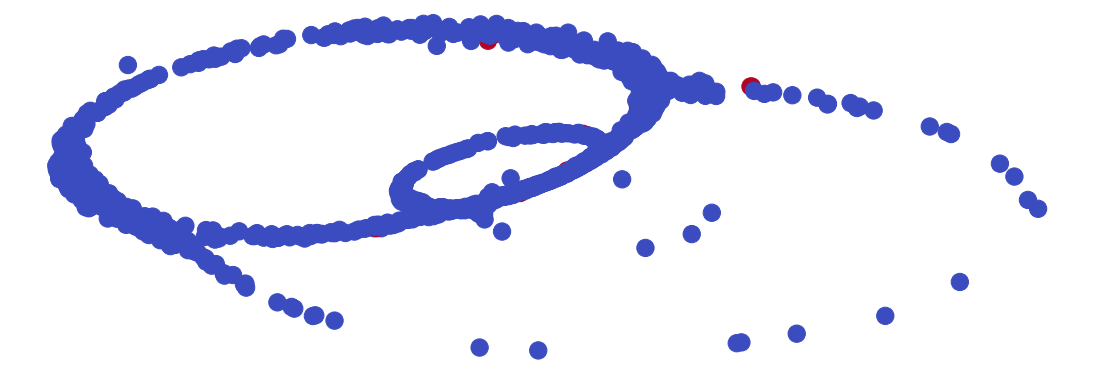

In [16]:
color_map = []
for cl in cluster.labels_:
    color_map.append(color_map_color(cl*10))

nx.draw(G,edge_color ='w', node_color=color_map)
plt.show()

In [17]:
#calculate the precision of clustering by labeled data 
exploratory_analysis=list()
for el in ld:
    midle_list=list()
    label_tag =el[0]
    label_distance=el[1].copy()
    label_distance.append(0)
    distance_matrix=dc.copy()
    distance_matrix.append(label_distance)
    DMX=creat_Symmetric_matrix(distance_matrix)
    Labels = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage = 'average').fit(DMX).labels_

    #extract lable  and labele it from the item we put at the end
    for i , x in enumerate(Labels):
        if i!=(len(Labels)-1):
            if x==Labels[-1]:
                midle_list.append(i)
    exploratory_analysis.append([label_tag,midle_list])
actg=dict()
for ev,x in exploratory_analysis:
    if ev in actg:
        actg[ev].append(x)
    else:
        actg.update({ev:[x]})

In [18]:
#calculate the Probibility of being event of temp_event
Prob_threshold=0.2
precision=list()

for event_name in actg:
    flat_list=list(dict.fromkeys(flatten(actg[event_name])))
    dprecision=list()
    for S in flat_list:
        x=0
        Number=len(actg[event_name])
        for i in range(Number):
            if S in actg[event_name][i]:
                x=x+1
        Probability=x/Number
        if Probability > Prob_threshold:
            dprecision.append((S,Probability))
    precision.append((event_name,dprecision))

as you can see its the Selected event and their Probability

In [19]:
precision[0]

('curva_direita_agressiva',
 [(17, 0.5),
  (18, 0.5),
  (19, 0.5),
  (20, 0.5),
  (21, 0.5),
  (22, 0.5),
  (265, 0.5),
  (266, 0.5),
  (267, 0.5),
  (482, 0.5),
  (483, 0.5),
  (484, 0.5),
  (485, 0.5),
  (234, 0.3333333333333333),
  (236, 0.3333333333333333),
  (455, 0.3333333333333333),
  (456, 0.3333333333333333)])

as you can see its the Selected event and their Probability

In [20]:
precision[1]

('evento_nao_agressivo',
 [(0, 1.0),
  (1, 1.0),
  (2, 1.0),
  (3, 1.0),
  (4, 1.0),
  (5, 1.0),
  (6, 1.0),
  (7, 1.0),
  (8, 1.0),
  (9, 1.0),
  (10, 1.0),
  (11, 1.0),
  (12, 1.0),
  (13, 1.0),
  (23, 1.0),
  (24, 1.0),
  (25, 1.0),
  (26, 1.0),
  (27, 1.0),
  (28, 1.0),
  (29, 1.0),
  (30, 1.0),
  (31, 1.0),
  (32, 1.0),
  (33, 1.0),
  (34, 1.0),
  (35, 1.0),
  (36, 1.0),
  (37, 1.0),
  (38, 1.0),
  (39, 1.0),
  (40, 1.0),
  (41, 1.0),
  (42, 1.0),
  (43, 1.0),
  (44, 1.0),
  (45, 1.0),
  (46, 1.0),
  (47, 1.0),
  (48, 1.0),
  (49, 1.0),
  (50, 1.0),
  (51, 1.0),
  (52, 1.0),
  (53, 1.0),
  (54, 1.0),
  (55, 1.0),
  (56, 1.0),
  (57, 1.0),
  (58, 1.0),
  (59, 1.0),
  (60, 1.0),
  (61, 1.0),
  (62, 1.0),
  (63, 1.0),
  (64, 1.0),
  (65, 1.0),
  (66, 1.0),
  (67, 1.0),
  (68, 1.0),
  (69, 1.0),
  (70, 1.0),
  (71, 1.0),
  (72, 1.0),
  (73, 1.0),
  (74, 1.0),
  (75, 1.0),
  (76, 1.0),
  (77, 1.0),
  (78, 1.0),
  (79, 1.0),
  (80, 1.0),
  (81, 1.0),
  (82, 1.0),
  (83, 1.0),
  (84, 1.0

but in the others event we have nothing to say because its too much data and it seems somethings goes wrong

maybe if we increase Data , and done this algorithm again could be conclude something


In [21]:
precision[2]

('curva_esquerda_agressiva',
 [(0, 0.8333333333333334),
  (1, 0.8333333333333334),
  (2, 0.8333333333333334),
  (3, 0.8333333333333334),
  (4, 0.8333333333333334),
  (5, 0.8333333333333334),
  (6, 0.8333333333333334),
  (7, 0.8333333333333334),
  (8, 0.8333333333333334),
  (9, 0.8333333333333334),
  (10, 0.8333333333333334),
  (11, 0.8333333333333334),
  (12, 0.8333333333333334),
  (13, 0.8333333333333334),
  (23, 0.8333333333333334),
  (24, 0.8333333333333334),
  (25, 0.8333333333333334),
  (26, 0.8333333333333334),
  (27, 0.8333333333333334),
  (28, 0.8333333333333334),
  (29, 0.8333333333333334),
  (30, 0.8333333333333334),
  (31, 0.8333333333333334),
  (32, 0.8333333333333334),
  (33, 0.8333333333333334),
  (34, 0.8333333333333334),
  (35, 0.8333333333333334),
  (36, 0.8333333333333334),
  (37, 0.8333333333333334),
  (38, 0.8333333333333334),
  (39, 0.8333333333333334),
  (40, 0.8333333333333334),
  (41, 0.8333333333333334),
  (42, 0.8333333333333334),
  (43, 0.8333333333333334),
 

In [10]:
#plot and optimize the number of the cluster and the linkage method
def Mean(dprecision):
    return np.mean(list(dict(dprecision).values()))

def Oploter(number_of_cluster , linkage_method):
    #calculate the precision of clustering by labeled data 
    exploratory_analysis=list()
    for el in ld:
        midle_list=list()
        label_tag =el[0]
        label_distance=el[1].copy()
        label_distance.append(0)
        distance_matrix=dc.copy()
        distance_matrix.append(label_distance)
        DMX=creat_Symmetric_matrix(distance_matrix)
        Labels = AgglomerativeClustering(n_clusters=number_of_cluster, affinity='precomputed', linkage = linkage_method).fit(DMX).labels_

        #extract lable  and labele it from the item we put at the end
        for i , x in enumerate(Labels):
            if i!=(len(Labels)-1):
                if x==Labels[-1]:
                    midle_list.append(i)
        exploratory_analysis.append([label_tag,midle_list])
    actg=dict()
    for ev,x in exploratory_analysis:
        if ev in actg:
            actg[ev].append(x)
        else:
            actg.update({ev:[x]})
    #calculate the Probibility of being event of temp_event
    Prob_threshold=0.1
    precision=list()
    for event_name in actg:
        flat_list=list(dict.fromkeys(flatten(actg[event_name])))
        dprecision=list()
        for S in flat_list:
            x=0
            Number=len(actg[event_name])
            for i in range(Number):
                if S in actg[event_name][i]:
                    x=x+1
            Probability=x/Number
            if Probability > Prob_threshold:
                dprecision.append((S,Probability))
        precision.append((event_name,len(dprecision),Mean(dprecision),dprecision))
    return precision


In [23]:
#linkage method average
linkage_mth='average'
Ya=list()
t1=time.time()
for num_cl in range(1,500,10):
    X=Oploter(num_cl,linkage_mth)
    Ya.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

47 min has time for calculaton distant


No handles with labels found to put in legend.


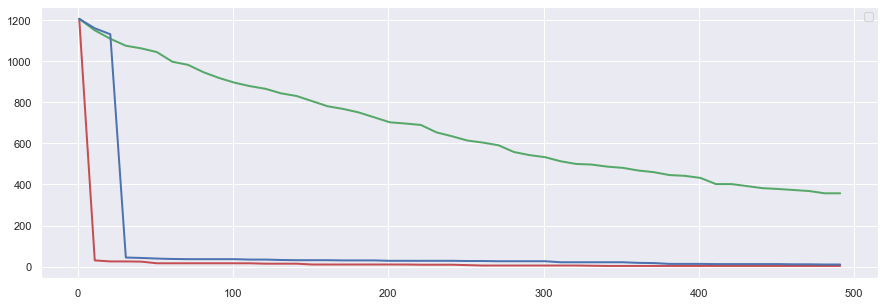

In [24]:
Ya_N1=[x[0][1] for x in Ya]
Ya_N2=[x[1][1] for x in Ya]
Ya_N3=[x[2][1] for x in Ya]

X = range(1,500,10)
fig, ax = plt.subplots()

ax.plot(X,Ya_N1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Ya_N3, linestyle='-', linewidth=2,c='b')


ax.legend();
plt.show() 

No handles with labels found to put in legend.


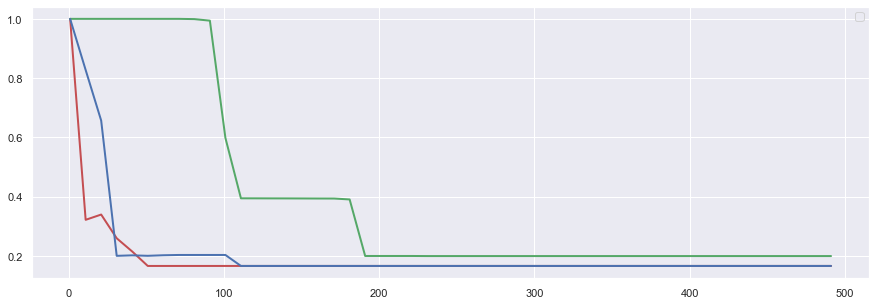

In [25]:
Ya_Q1=[x[0][2] for x in Ya]
Ya_Q2=[x[1][2] for x in Ya]
Ya_Q3=[x[2][2] for x in Ya]

X = range(1,500,10)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='g')
ax.plot(X,Ya_Q3, linestyle='-', linewidth=2,c='b')
ax.legend();
plt.show() 

In [23]:
#linkage method average
linkage_mth='average'
Ya=list()
t1=time.time()
for num_cl in range(8,30):
    X=Oploter(num_cl,linkage_mth)
    Ya.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

20 min has time for calculaton distant


No handles with labels found to put in legend.


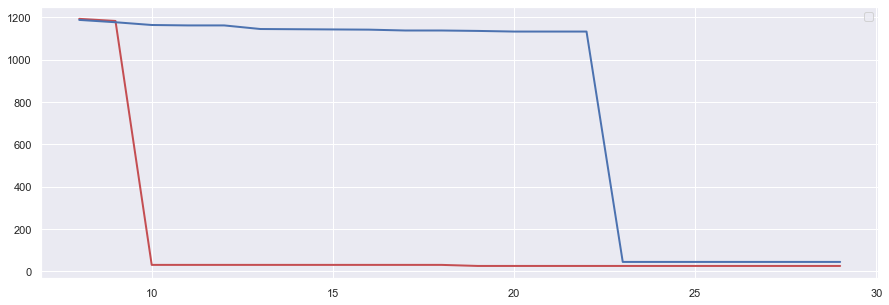

In [24]:
Ya_N1=[x[0][1] for x in Ya]
Ya_N3=[x[2][1] for x in Ya]

X = range(8,30)
fig, ax = plt.subplots()

ax.plot(X,Ya_N1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_N3, linestyle='-', linewidth=2,c='b')


ax.legend();
plt.show() 

No handles with labels found to put in legend.


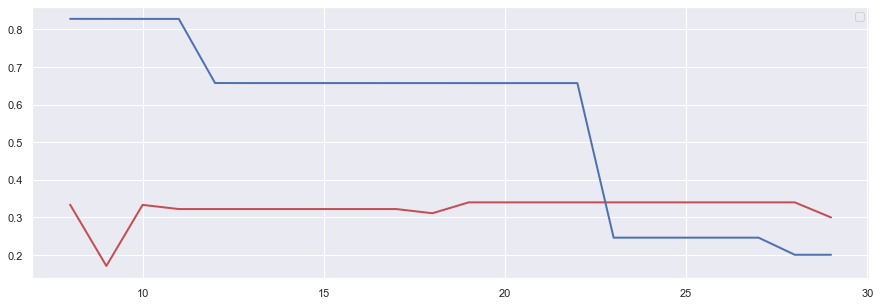

In [25]:
Ya_Q1=[x[0][2] for x in Ya]
Ya_Q3=[x[2][2] for x in Ya]

X = range(8,30)

fig, ax = plt.subplots()

ax.plot(X,Ya_Q1, linestyle='-', linewidth=2,c='r')
ax.plot(X,Ya_Q3, linestyle='-', linewidth=2,c='b')
ax.legend();
plt.show() 

In [33]:
#linkage method average
linkage_mth='average'
Yn=list()
t1=time.time()
for num_cl in range(100,1000,50):
    X=Oploter(num_cl,linkage_mth)
    Yn.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret

20 min has time for calculaton distant


C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No handles with labels found to put in legend.


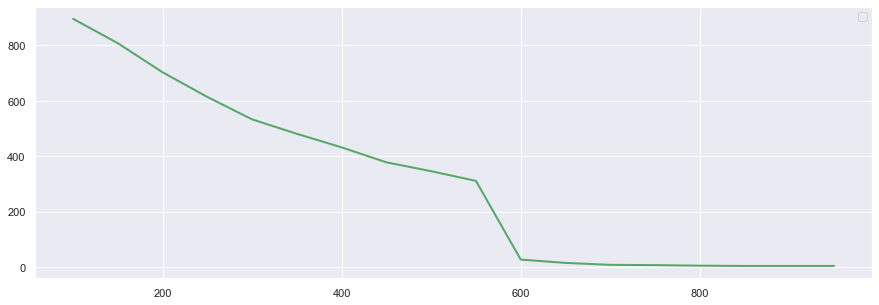

In [38]:
Ya_N2=[x[1][1] for x in Yn]

X = range(100,1000,50)
fig, ax = plt.subplots()
ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


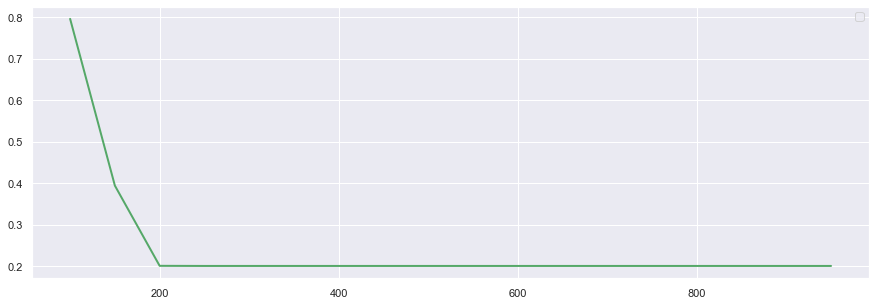

In [40]:
Ya_Q2=[x[1][2] for x in Yn]

X = range(100,1000,50)

fig, ax = plt.subplots()
ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='g')
ax.legend();
plt.show() 

In [41]:
#linkage method average
linkage_mth='average'
Yn=list()
t1=time.time()
for num_cl in range(550,600):
    X=Oploter(num_cl,linkage_mth)
    Yn.append(X)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')

49 min has time for calculaton distant


No handles with labels found to put in legend.


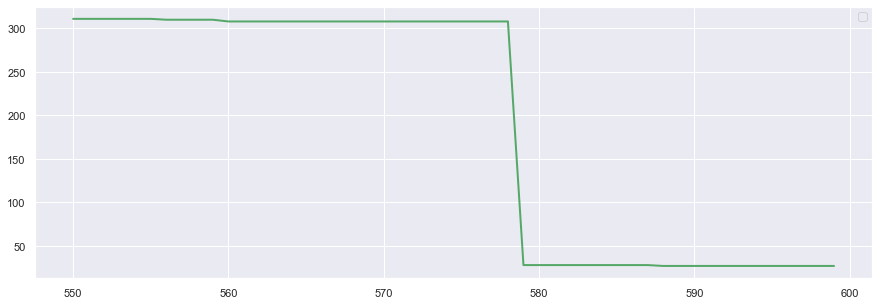

In [42]:
Ya_N2=[x[1][1] for x in Yn]

X = range(550,600)
fig, ax = plt.subplots()
ax.plot(X,Ya_N2, linestyle='-', linewidth=2,c='g')

ax.legend();
plt.show() 

No handles with labels found to put in legend.


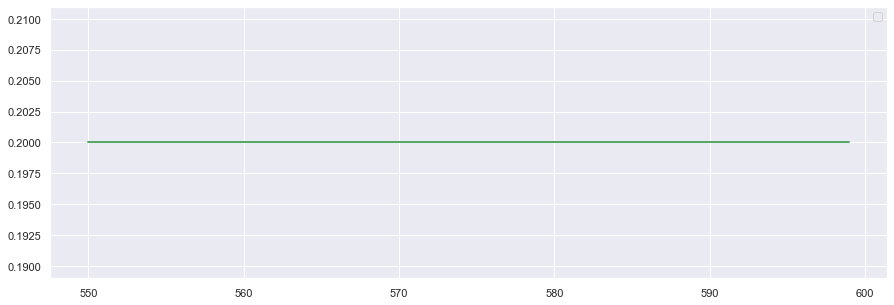

In [43]:
Ya_Q2=[x[1][2] for x in Yn]

X = range(550,600)

fig, ax = plt.subplots()
ax.plot(X,Ya_Q2, linestyle='-', linewidth=2,c='g')
ax.legend();
plt.show() 

In [44]:
OptimizeEvent=list()
OptimizeEvent.append(Ya[10-8][0])#red
OptimizeEvent.append(Yn[579-550][1])#green
OptimizeEvent.append(Ya[24-8][2])#blue

#Save labeds distance matrix
with open("OptimizeLabeldEvent_on20.txt", "wb") as fp:
    pickle.dump(OptimizeEvent, fp)

In [45]:
#load File , save the time of calculation
with open("OptimizeLabeldEvent_on20.txt", "rb") as fp:
    oe = pickle.load(fp)

In [46]:
oe

[('curva_direita_agressiva',
  30,
  0.3333333333333333,
  [(17, 0.5),
   (18, 0.5),
   (19, 0.5),
   (20, 0.5),
   (21, 0.5),
   (22, 0.5),
   (265, 0.5),
   (266, 0.5),
   (267, 0.5),
   (482, 0.5),
   (483, 0.5),
   (484, 0.5),
   (485, 0.5),
   (165, 0.16666666666666666),
   (166, 0.16666666666666666),
   (167, 0.16666666666666666),
   (168, 0.16666666666666666),
   (169, 0.16666666666666666),
   (170, 0.16666666666666666),
   (171, 0.16666666666666666),
   (172, 0.16666666666666666),
   (234, 0.3333333333333333),
   (236, 0.3333333333333333),
   (237, 0.16666666666666666),
   (238, 0.16666666666666666),
   (239, 0.16666666666666666),
   (455, 0.3333333333333333),
   (456, 0.3333333333333333),
   (454, 0.16666666666666666),
   (481, 0.16666666666666666)]),
 ('evento_nao_agressivo',
  28,
  0.20000000000000004,
  [(326, 0.2),
   (387, 0.2),
   (756, 0.2),
   (609, 0.2),
   (610, 0.2),
   (611, 0.2),
   (612, 0.2),
   (613, 0.2),
   (614, 0.2),
   (615, 0.2),
   (616, 0.2),
   (617, 